In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [47]:
from collections import defaultdict as ddict
def fil_name2paras(fil_name):
    """plz be careful about 0.1 and 1
    """
    tmp = fil_name.split("_")
    paras = {}
    for itm in tmp:
        if '--' in itm:
            k, v = itm.split("--")
            v = f"0.{v}"
        elif '-' in itm:
            k, v = itm.split("-")
            # to be compatible with old simu
            if v.startswith("0"):
                v = f"0.{v}"
        else:
            continue
        
        if k.startswith("T"):
            k = "n_T"
        elif k.startswith("decay"):
            k = "weight_decay"
        elif k.startswith("infeat"):
            k = "n_infeat"
        paras[k] = float(v)
    paras["rep"] = int(tmp[1])
    return paras

def _add_res(res, key):
    if key not in res.keys():
        return None
    all_res["Len"].append(res[key][-1])
    all_res["ITE"].append(res[key][0][0])
    all_res["CATE"].append(res[key][0][1])
    all_res["method"].append(key)
    for ky, v in cur_paras.items():
        all_res[ky].append(v)

#res_dir = RES_ROOT/"demodp0mysettingtest_ablation_setting1_d10_n3000"
res_dir = RES_ROOT/"simu_ablation_setting3_d100_n3000"
all_fils = list(res_dir.glob("*n_T-*.pkl"));
all_res = ddict(list)
for fil in all_fils:
    cur_paras = fil_name2paras(fil.stem);
    res = load_pkl(fil, verbose=False);
    
    _add_res(res, key="DDPM")
    _add_res(res, key="DDPM_sel")
    _add_res(res, key="DDPM_val")
    _add_res(res, key="DDPM_sel_val")
    _add_res(res, key="CQR")
all_res_df = pd.DataFrame(all_res);

#all_res_df = pd.concat([all_res_df1, all_res_df]);
def _fn(x):
    if "sel" in x:
        x = f"3-{x}"
    elif x.endswith("CQR"):
        x = f"1-{x}"
    else:
        x = f"2-{x}"
    return x
all_res_df["method1"] = all_res_df["method"].map(_fn)

In [48]:
# check all hyper-param combos
grp_var = ["n_T", "n_infeat", "upblk",  "downblk", "weight_decay",  "lr"]
all_res_df[all_res_df["method"] == "DDPM"].groupby(grp_var)[["ITE"]].agg(["count"])

ITE
                                                  count
n_T     n_infeat upblk downblk weight_decay lr         
100.000 128.000  1.000 1.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
                 3.000 3.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
                 5.000 5.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
        512.000  1.000 1.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
                 3.000 3.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
                 5.000 5.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
200.000 128.000  1.000 1.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
                 3.000 3.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
                 5.000 5.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
        512.000  1.000 1.000   0.010        0.010    50
                                            0.100    50
                                            0.500    50
                 3.000 3.000   0.010        0.010     5
                                            0.100    49
                                            0.500    50
400.000 128.000  1.000 1.000   0.010        0.010    50
                                            0.100    50
                               0.100        0.010    50
                                            0.100    50
                 3.000 3.000   0.010        0.010    50
                                            0.100    50
                               0.100        0.010    50
                                            0.100    50
                 5.000 5.000   0.010        0.010    50
                                            0.100    50
                               0.100        0.010    50
                                            0.100    50
        512.000  1.000 1.000   0.010        0.010    49
                                            0.100    50
                               0.100        0.010     4
                                            0.100    50

In [49]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
data = all_res_df[all_res_df["method"].isin(["DDPM", "DDPM_sel"])];
data = data[data["Len"].map(lambda x : np.bitwise_not(np.isnan(x)))];
Q1, Q3 = data["Len"].quantile([0.25, 0.75]) 
lb, ub = Q1 - 1.5 * (Q3-Q1), Q3 + 1.5 * (Q3-Q1)
data = data[(data["Len"] < ub) & (data["Len"] > lb)].copy()
#data.reindex()
def _std(df, col):
    return df[col].map(lambda x: (x-df[col].mean())/df[col].std())
#data.loc[:, "x_method"] =  data["method"].map(lambda x: 0 if x=="DDPM" else 1)
data.loc[:, "x_nblk"] = _std(data, "upblk")
data.loc[:, "x_n_infeat"] = _std(data, "n_infeat")

data.head()
dum_vars =["lr", "n_T", "weight_decay", "method"]
data_wdum = pd.get_dummies(data, prefix=["x_"+ dum_var for dum_var in dum_vars], columns=dum_vars, drop_first=True)
x_cols = data_wdum.filter(regex='^x_')
x_cols = sm.add_constant(x_cols)
y = data_wdum.loc[:, "Len"];

model = sm.OLS(y, x_cols).fit()
model.summary2()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.480     
Dependent Variable: Len              AIC:                14283.7425
Date:               2024-01-01 14:14 BIC:                14341.0357
No. Observations:   4298             Log-Likelihood:     -7132.9   
Df Model:           8                F-statistic:        496.2     
Df Residuals:       4289             Prob (F-statistic): 0.00      
R-squared:          0.481            Scale:              1.6215    
-------------------------------------------------------------------
                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const               5.5757   0.0453 123.0154 0.0000  5.4868  5.6645
x_nblk             -0.0307   0.0202  -1.5223 0.1280 -0.0702  0.0088
x_n_infeat          0.0232   0.0208   1.1131 0.2657 -0.0177  0.0641
x_lr_0.1           -0.2556   0.0438  -5.8350 0.0000 -0.3415 -0.1697
x_lr_0.5            2.4679   0.0561  43.9660 0.0000  2.3578  2.5779
x_n_T_200.0         0.3288   0.0483   6.8039 0.0000  0.2341  0.4236
x_n_T_400.0         0.9115   0.0584  15.6208 0.0000  0.7971  1.0259
x_weight_decay_0.1  2.1737   0.0724  30.0139 0.0000  2.0317  2.3157
x_method_DDPM_sel  -0.0346   0.0390  -0.8880 0.3746 -0.1111  0.0418
-------------------------------------------------------------------
Omnibus:              207.783       Durbin-Watson:          1.416  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       265.188
Skew:                 0.489         Prob(JB):               0.000  
Kurtosis:             3.724         Condition No.:          6      
===================================================================

"""

# Select com for each rep

In [50]:
best_res = []
for cur_rep in list(set(all_res_df["rep"])):
    kpidx = np.bitwise_and(all_res_df["rep"] == cur_rep, all_res_df["method"].isin(["DDPM_val", "DDPM_sel_val"]));
    kpidx = np.bitwise_and(kpidx, all_res_df["ITE"]>0.95)
    if kpidx.sum() == 0:
        kpidx = np.bitwise_and(all_res_df["rep"] == cur_rep, all_res_df["method"].isin(["DDPM_val", "DDPM_sel_val"]))
    
    best_val = all_res_df[kpidx].sort_values(by="Len").iloc[0]
    cols = ["method", "lr", "n_infeat", "n_T", "weight_decay", "upblk", "downblk", "rep"]
    mask = np.ones(all_res_df.shape[0], dtype=bool)
    mask_cqr = np.ones(all_res_df.shape[0], dtype=bool)
    for col in cols:
        if col.startswith("method"):
            #v = best_val[col]
            v = best_val[col].split("_val")[0]
            mask = np.bitwise_and(mask, all_res_df[col].isin([v, "CQR"]))
        else: 
            v = best_val[col]
            mask = np.bitwise_and(mask, all_res_df[col] == v)
    best_res.append(all_res_df[mask])
best_res = pd.concat(best_res);
best_res["method2"] = best_res["method"].map(lambda x: x.split("_")[0])
best_res.groupby("method2")[["Len", "ITE"]].agg(["mean", "median", "std", "count"])

Len                      ITE                   
         mean median   std count  mean median   std count
method2                                                  
CQR     4.930  4.924 0.219    50 0.944  0.944 0.014    50
DDPM    4.584  4.382 0.537    50 0.931  0.935 0.015    50

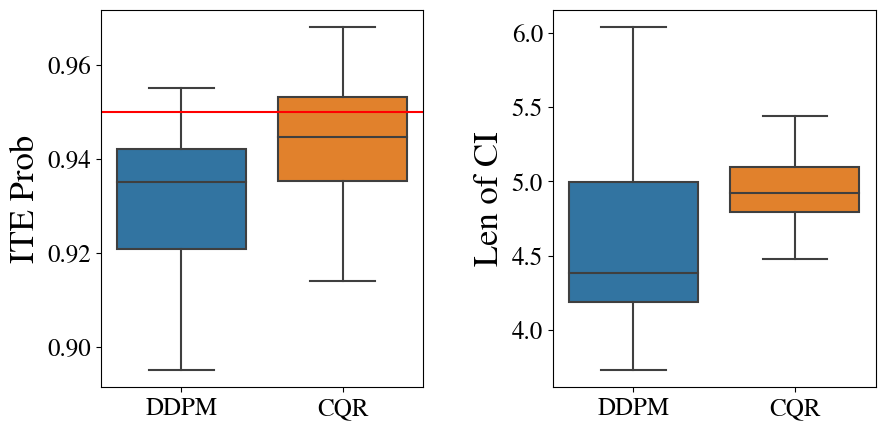

In [51]:
plt.subplot(121)
sns.boxplot(data=best_res, y="ITE", x="method2")
plt.axhline(y=0.95, color="red");
plt.xlabel("")
plt.ylabel("ITE Prob")
plt.subplot(122)
sns.boxplot(data=best_res, y="Len", x="method2")
plt.xlabel("")
plt.ylabel("Len of CI");

# Select com by mean

In [52]:
pd.set_option('display.float_format', '{:.3f}'.format)
res_df = all_res_df.groupby(["n_infeat", "upblk", 
                             "downblk", "weight_decay", 
                             "lr", "n_T",   "method1"])[["Len", "ITE"]].agg(["mean", "median", "std", "count"]);

base_idxs = np.bitwise_and(res_df[('Len',  'count')] == 50, res_df.index.map(lambda x: "CQR" in x[-1]))

val_df = res_df[res_df.index.map(lambda x: "val" in x[-1])]
sorted_val_idx = val_df[("Len", "median")].sort_values().index
sorted_test_idx = pd.MultiIndex.from_tuples([tuple(list(ix[:-1])+[ix[-1].split("_val")[0]]) for ix in sorted_val_idx], 
                                            names=sorted_val_idx.names);

pd.concat([res_df[base_idxs].iloc[:1],  res_df.loc[sorted_test_idx]]).head(n=30)

Len         \
                                                              mean median   
n_infeat upblk downblk weight_decay lr    n_T     method1                   
128.000  1.000 1.000   0.010        0.010 100.000 1-CQR      4.930  4.924   
512.000  3.000 3.000   0.010        0.010 200.000 3-DDPM_sel 5.226  4.930   
128.000  3.000 3.000   0.010        0.100 100.000 3-DDPM_sel 5.168  5.010   
512.000  3.000 3.000   0.010        0.010 200.000 2-DDPM     5.132  4.951   
                                    0.100 200.000 3-DDPM_sel 5.167  5.087   
128.000  5.000 5.000   0.010        0.100 100.000 3-DDPM_sel 5.189  5.075   
         3.000 3.000   0.010        0.100 100.000 2-DDPM     5.194  5.091   
                                          200.000 3-DDPM_sel 5.330  5.144   
512.000  5.000 5.000   0.010        0.100 100.000 3-DDPM_sel 5.195  5.102   
128.000  5.000 5.000   0.010        0.100 100.000 2-DDPM     5.326  5.093   
512.000  3.000 3.000   0.010        0.100 100.000 2-DDPM     5.329  5.153   
         1.000 1.000   0.010        0.100 200.000 3-DDPM_sel 5.341  5.190   
128.000  1.000 1.000   0.010        0.100 100.000 3-DDPM_sel 5.212  5.305   
512.000  1.000 1.000   0.010        0.100 100.000 2-DDPM     5.216  5.228   
         5.000 5.000   0.010        0.100 100.000 2-DDPM     5.284  5.330   
128.000  5.000 5.000   0.010        0.100 200.000 3-DDPM_sel 5.243  5.211   
512.000  3.000 3.000   0.010        0.100 100.000 3-DDPM_sel 5.312  5.329   
128.000  1.000 1.000   0.010        0.100 200.000 3-DDPM_sel 5.390  5.363   
         5.000 5.000   0.010        0.010 100.000 2-DDPM     5.400  5.267   
         1.000 1.000   0.010        0.100 100.000 2-DDPM     5.376  5.330   
512.000  1.000 1.000   0.010        0.100 200.000 2-DDPM     5.452  5.331   
128.000  1.000 1.000   0.010        0.100 200.000 2-DDPM     5.471  5.382   
512.000  3.000 3.000   0.010        0.100 200.000 2-DDPM     5.505  5.467   
128.000  3.000 3.000   0.010        0.010 100.000 3-DDPM_sel 5.795  5.445   
512.000  5.000 5.000   0.010        0.010 100.000 2-DDPM     5.500  5.337   
128.000  5.000 5.000   0.010        0.100 200.000 2-DDPM     5.564  5.404   
         3.000 3.000   0.010        0.010 100.000 2-DDPM     5.477  5.204   
512.000  3.000 3.000   0.010        0.010 100.000 3-DDPM_sel 5.799  5.594   
         1.000 1.000   0.010        0.100 100.000 3-DDPM_sel 5.362  5.492   
         3.000 3.000   0.010        0.010 100.000 2-DDPM     5.507  5.539   

                                                                          \
                                                               std count   
n_infeat upblk downblk weight_decay lr    n_T     method1                  
128.000  1.000 1.000   0.010        0.010 100.000 1-CQR      0.219    50   
512.000  3.000 3.000   0.010        0.010 200.000 3-DDPM_sel 0.592     5   
128.000  3.000 3.000   0.010        0.100 100.000 3-DDPM_sel 0.923    50   
512.000  3.000 3.000   0.010        0.010 200.000 2-DDPM     0.377     5   
                                    0.100 200.000 3-DDPM_sel 0.725    49   
128.000  5.000 5.000   0.010        0.100 100.000 3-DDPM_sel 0.908    50   
         3.000 3.000   0.010        0.100 100.000 2-DDPM     0.858    50   
                                          200.000 3-DDPM_sel 0.843    50   
512.000  5.000 5.000   0.010        0.100 100.000 3-DDPM_sel 0.923    50   
128.000  5.000 5.000   0.010        0.100 100.000 2-DDPM     0.949    50   
512.000  3.000 3.000   0.010        0.100 100.000 2-DDPM     0.868    50   
         1.000 1.000   0.010        0.100 200.000 3-DDPM_sel 0.596    50   
128.000  1.000 1.000   0.010        0.100 100.000 3-DDPM_sel 0.791    50   
512.000  1.000 1.000   0.010        0.100 100.000 2-DDPM     0.789    50   
         5.000 5.000   0.010        0.100 100.000 2-DDPM     0.855    50   
128.000  5.000 5.000   0.010        0.100 200.000 3-DDPM_sel 0.589    50   
512.000  3.000 3.000   0.010        0.100 100.000 3-DDPM_sel 0.809    50   
1

In [128]:
grp_var = ["n_infeat", "upblk",  "downblk", "weight_decay",  "lr", "n_T",   "method1"]
grp_var = [ "method1"]
agg_var = ["mean", "median", "std", "count"]
res_df = all_res_df[all_res_df["method1"].map(lambda x: "DDPM" in x)].groupby(grp_var)[["Len", "ITE"]].agg(agg_var);
res_df

Len                                 ITE         \
                         mean median              std count  mean median   
method1                                                                    
2-DDPM         4034876354.308  5.859 181550545147.979  2025 0.948  0.955   
2-DDPM_val     4032261993.226  5.930 181433547622.838  2025 0.945  0.953   
3-DDPM_sel              6.206  5.596            2.391  2039 0.955  0.955   
3-DDPM_sel_val          6.244  5.656            2.431  2039 0.951  0.953   

                            
                 std count  
method1                     
2-DDPM         0.080  2039  
2-DDPM_val     0.081  2039  
3-DDPM_sel     0.013  2039  
3-DDPM_sel_val 0.020  2039

In [30]:
#res_df.to_html("all_res.html");
#pd.set_option('display.float_format', '{:.3f}'.format)


# Get result under best combone

In [26]:
def get_res_at_com(all_res_df, com):
    kpidx = np.ones(all_res_df.shape[0], dtype=bool)
    for ky, v in com.items():
        if ky == "method":
            continue
        kpidx = np.bitwise_and(kpidx,all_res_df[ky] == v)
    return all_res_df[kpidx]

In [27]:
best_com = dict()
best_com["n_infeat"] = 128
best_com["upblk"] = 3
best_com["downblk"] = 3
best_com["weight_decay"] = 0.01
best_com["lr"] = 0.01
best_com["n_T"] = 100
best_com["method"] = "DDPM_sel"

In [22]:
res_df = get_res_at_com(all_res_df, best_com);
res_df = res_df[res_df["method"].isin(["CQR", best_com['method']])]
res_df.head()

,Len,ITE,CATE,method,lr,n_infeat,n_T,weight_decay,upblk,downblk,rep
19,6.524714,0.923,0.998,DDPM_sel,0.01,128.0,100.0,0.01,3.0,3.0,32
20,5.465805,0.944,0.998,CQR,0.01,128.0,100.0,0.01,3.0,3.0,32
25,9.175587,0.957,0.981,DDPM_sel,0.01,128.0,100.0,0.01,3.0,3.0,0
26,5.459108,0.934,1.000,CQR,0.01,128.0,100.0,0.01,3.0,3.0,0
34,9.436742,0.958,0.980,DDPM_sel,0.01,128.0,100.0,0.01,3.0,3.0,38


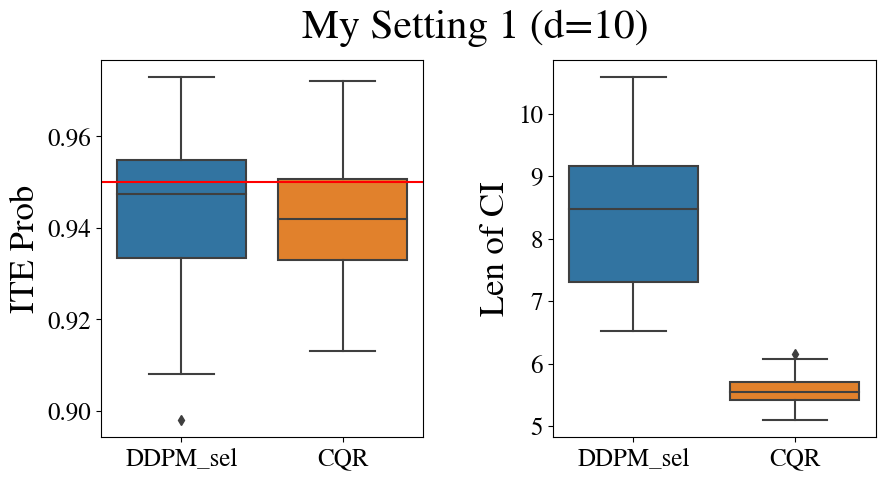

In [23]:
plt.suptitle(f"My Setting 1 (d=10)", fontsize=30)
plt.subplot(121)
sns.boxplot(data=res_df, y="ITE", x="method")
plt.axhline(y=0.95, color="red");
plt.xlabel("")
plt.ylabel("ITE Prob")
plt.subplot(122)
sns.boxplot(data=res_df, y="Len", x="method")
plt.xlabel("")
plt.ylabel("Len of CI");